<h3> Try to run solve() from notebook using Dask to parallell np.linalg.eigh() loo

In [12]:
import sys
import time
import numpy as np
import pickle
import dask
from numba import njit, prange
import scipy
import matplotlib.pyplot as plt

sys.path.append("/Users/martinedh/Documents/NTNU/GitHub/FysMat/Prosjektoppgave")
from utilities_t import idx_F_i, num_idx_F_i
from main import run_eigh_calc, solve_and_test_small_system
from main import f as fa
from solve_hamiltonian import solve_system
from system_class import System
from system_helper import set_hamiltonian, update_hamiltonian
from system_helper import calculate_F_matrix

<h4> Dask

In [2]:
# https://www.youtube.com/watch?v=wANQkgDuTAk

from dask.distributed import Client, LocalCluster, fire_and_forget
from dask import delayed

In [3]:
#  client.restart

In [4]:
cluster = LocalCluster(n_workers=4, threads_per_worker=3)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:60494 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 17.18 GB


In [5]:
@delayed
@njit(fastmath=True)
def calculate_eigh(ham):
    return np.linalg.eigh(ham)

In [6]:
system = System(phase=0.0, L_y = 30,L_z=30, L_sc_0 = 25, L_nc=0, L_sc=25, L_soc=3, mu_sc = 0.9, mu_nc = 0.9, mu_soc = 0.85, u_sc = -4.2, beta=33.3)

junction=True
tol=1e-4
max_num_iter=100
tmp_num_iter = 0
num_delta_over_tol = system.L_x
delta_store = np.ones((system.L_x, 2), dtype=np.complex128) # 1.column NEW, 2.column OLD



In [23]:

def calcualte_hamiltonian_all(system):
    hamiltonian_all = np.zeros(shape=(system.L_x * 4, system.L_x * 4, system.L_y, system.L_z), dtype=np.complex128)
    for ky_idx in range(1, len(system.ky_array)): # form k=-pi to k=pi
        for kz_idx in range(1, len(system.kz_array)):
            hamiltonian_all[:,:,ky_idx, kz_idx] = set_hamiltonian(ky=system.ky_array[ky_idx],
                                                                 kz=system.kz_array[kz_idx],
                                                                 hamiltonian=system.hamiltonian,
                                                                 L_x=system.L_x,
                                                                 L_sc=system.L_sc,
                                                                 L_soc=system.L_soc,
                                                                 mu_array=system.mu_array,
                                                                 t_array=system.t_x_array,
                                                                 U_array=system.U_array,
                                                                 F_matrix=system.F_matrix,
                                                                 h_array=system.h_array,
                                                                 alpha_R_x_array=system.alpha_R_x_array,
                                                                 alpha_R_y_array=system.alpha_R_y_array)
           #hamiltonian_all[:,:,ky_idx,kz_idx]
    return hamiltonian_all

In [8]:
%%time
hamiltonian_all = calcualte_hamiltonian_all()

CPU times: user 11.1 s, sys: 464 ms, total: 11.5 s
Wall time: 9.71 s


In [9]:
hamiltonian_all.shape

(212, 212, 30, 30)

In [33]:
import scipy
@njit(fastmath=True)
def calculate_eigen(hamiltonian_all, ky_len, kz_len):
    for ky_idx in range(1, ky_len): # form k=-pi to k=pi
        for kz_idx in range(1, kz_len):
            #X = hamiltonian_all[:,:,ky_idx,kz_idx]
            evalues, evectors = np.linalg.eigh(hamiltonian_all[:,:,ky_idx,kz_idx])
            #evalues, evectors = scipy.linalg.eigh(hamiltonian_all[:,:,ky_idx,kz_idx], b = np.eye(len(hamiltonian_all[:,:,ky_idx,kz_idx]), dtype = hamiltonian_all[:,:,ky_idx,kz_idx].dtype), turbo = True, check_finite = False)

In [34]:
%%time
calculate_eigen(hamiltonian_all, len(system.ky_array), len(system.kz_array))

CPU times: user 15.5 s, sys: 313 ms, total: 15.8 s
Wall time: 11.4 s


In [21]:
@njit(fastmath=True)
def calc_together(eigenvalues, eigenvectors, ky_array, kz_array, hamiltonian, L_x, L_sc, L_soc, mu_array, t_x_array, U_array, F_matrix, h_array, alpha_R_x_array, alpha_R_y_array):  
    for ky_idx in range(1, len(ky_array)): # form k=-pi to k=pi
        for kz_idx in range(1, len(kz_array)):
            hamiltonian = set_hamiltonian(ky=ky_array[ky_idx],
                                         kz=kz_array[kz_idx],
                                         hamiltonian=hamiltonian,
                                         L_x=L_x,
                                         L_sc=L_sc,
                                         L_soc=L_soc,
                                         mu_array=mu_array,
                                         t_array=t_x_array,
                                         U_array=U_array,
                                         F_matrix=F_matrix,
                                         h_array=h_array,
                                         alpha_R_x_array=alpha_R_x_array,
                                         alpha_R_y_array=alpha_R_y_array)
            # Calculates the eigenvalues from hamiltonian.
            eigenvalues[:, ky_idx, kz_idx], eigenvectors[:, :, ky_idx, kz_idx] = np.linalg.eigh(hamiltonian)

In [23]:
%%time

calc_together(system.eigenvalues,
              system.eigenvectors,
              system.ky_array, 
              system.kz_array, 
              system.hamiltonian, 
              system.L_x, 
              system.L_sc, 
              system.L_soc, 
              system.mu_array, 
              system.t_x_array, 
              system.U_array, 
              system.F_matrix, 
              system.h_array, 
              system.alpha_R_x_array, 
              system.alpha_R_y_array)

CPU times: user 18.7 s, sys: 581 ms, total: 19.2 s
Wall time: 11.1 s


In [10]:
#%%time
#hamiltonian_all = dask.compute(hamiltonian_all[:])
#hamiltonian_all = hamiltonian_all[0]

In [10]:
delayed_objects = []
#while num_delta_over_tol > 0 and tmp_num_iter <= max_num_iter:
for ky_idx in range(1, len(system.ky_array)): # form k=-pi to k=pi
    for kz_idx in range(1, len(system.kz_array)):
        # Calculates the eigenvalues from hamiltonian.
        delayed_objects.append(calculate_eigh(hamiltonian_all[:,:,ky_idx,kz_idx]))

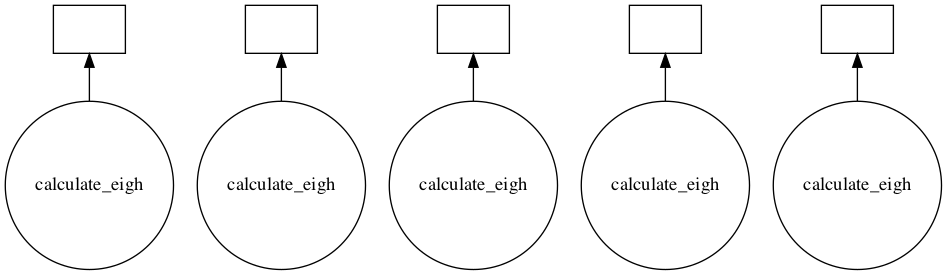

In [11]:
dask.visualize(delayed_objects[:5])

In [12]:
%%time

f = dask.compute(*delayed_objects)

CPU times: user 9.15 s, sys: 2.52 s, total: 11.7 s
Wall time: 20 s


In [13]:
evals, evecs = map(list,zip(*f))

In [14]:
system.eigenvalues[:,1:,1:] = np.reshape(np.array(evals), (212, 29, 29))
system.eigenvectors[:,:,1:,1:] = np.reshape(np.array(evecs), (212,212, 29, 29))

In [15]:
system.F_matrix = calculate_F_matrix(F_matrix=system.F_matrix,
                                             L_x=system.L_x,
                                             L_y=system.L_y,
                                             L_z=system.L_z,
                                             eigenvalues=system.eigenvalues,
                                             eigenvectors=system.eigenvectors,
                                             beta=system.beta)
if junction==True:
    #F_matrix = forcePhaseDifference(F_matrix=F_matrix,
                                    #phase=phase)
    system.F_matrix[0, 0] = np.abs(system.F_matrix[0, 0]) * np.exp(1.0j * system.phase)  # phase_plus
    system.F_matrix[-1, 0] = np.abs(system.F_matrix[-1, 0])

delta_store[:, 0] = system.F_matrix[:, idx_F_i]  # F_ii
#delta_diff = abs((delta_store[:, 0] - delta_store[:, 1]) / delta_store[:, 1])
delta_diff_tmp = (delta_store[:, 0] - delta_store[:, 1])
delta_diff_tmp /= delta_store[:, 1]
delta_diff = np.abs(delta_diff_tmp)
delta_store[:, 1] = system.F_matrix[:, idx_F_i]  # F_ii
tmp_num_iter += 1

num_delta_over_tol = len(np.where(delta_diff > tol)[0])

In [16]:
system.F_matrix[:,0]

array([ 3.15631168e-04+0.j, -1.31471269e-03+0.j, -4.08571183e-05+0.j,
        6.16675475e-03+0.j, -3.62252061e-04+0.j, -2.23242774e-03+0.j,
        1.31752574e-03+0.j,  5.05368044e-04+0.j,  1.32740369e-03+0.j,
        4.99832868e-04+0.j,  4.45130995e-04+0.j, -8.52563629e-04+0.j,
        1.54220499e-04+0.j,  4.64100443e-04+0.j, -4.76373554e-04+0.j,
        1.08818707e-02+0.j, -7.82942915e-04+0.j, -4.38274594e-03+0.j,
       -1.05088610e-04+0.j, -1.41759219e-03+0.j, -3.98976409e-03+0.j,
        1.01625045e-03+0.j, -7.84472596e-03+0.j, -1.29448396e-03+0.j,
       -2.09000055e-03+0.j,  1.18162190e-03+0.j,  4.38443538e-03+0.j,
        7.05853937e-03+0.j, -1.22892439e-02+0.j,  4.05374933e-03+0.j,
       -1.30486324e-03+0.j, -6.13832331e-04+0.j, -1.41518401e-03+0.j,
        1.78609381e-04+0.j,  2.07911429e-03+0.j,  6.97817716e-04+0.j,
       -9.20473035e-04+0.j, -1.64465766e-03+0.j,  1.07224376e-03+0.j,
       -4.06830420e-03+0.j,  3.10924521e-04+0.j,  6.59622151e-04+0.j,
        2.51528164e-

<h5> while loop

In [16]:
%%time

system = System(phase=0.0, L_y = 30,L_z=30, L_sc_0 = 25, L_nc=0, L_sc=25, L_soc=3, mu_sc = 0.9, mu_nc = 0.9, mu_soc = 0.85, u_sc = -4.2, beta=33.3)

junction=True
tol=1e-5
max_num_iter=20

tmp_num_iter = 0
num_delta_over_tol = system.L_x
delta_store = np.ones((system.L_x, 2), dtype=np.complex128) # 1.column NEW, 2.column OLD



system.hamiltonain = set_hamiltonian(ky=system.ky_array[1],
                                     kz=system.kz_array[1],
                                     hamiltonian=system.hamiltonian,
                                     L_x=system.L_x,
                                     L_sc=system.L_sc,
                                     L_soc=system.L_soc,
                                     mu_array=system.mu_array,
                                     t_array=system.t_x_array,
                                     U_array=system.U_array,
                                     F_matrix=system.F_matrix,
                                     h_array=system.h_array,
                                     alpha_R_x_array=system.alpha_R_x_array,
                                     alpha_R_y_array=system.alpha_R_y_array)

while num_delta_over_tol > 0 and tmp_num_iter <= max_num_iter:
    print("Iteration nr. %i" % (tmp_num_iter + 1))
    #hamiltonian_all = calcualte_hamiltonian_all(system)
    
    #hamiltonian = np.zeros(shape=(53 * 4, 53 * 4, 30, 30), dtype=np.complex128)
    hamiltonian_tmp = np.zeros(shape=(system.L_x * 4, system.L_x * 4), dtype=np.complex128)
   
    delayed_objects = []

    for ky_idx in range(1, len(system.ky_array)): # form k=-pi to k=pi
        for kz_idx in range(1, len(system.kz_array)):
            hamiltonian_tmp[:,:] = update_hamiltonian(system.hamiltonian, 
                                                      U_array=system.U_array,
                                                      F_matrix=system.F_matrix,
                                                      L_x=system.L_x)


    
    #while num_delta_over_tol > 0 and tmp_num_iter <= max_num_iter:
    #for ky_idx in range(1, len(system.ky_array)): # form k=-pi to k=pi
    #    for kz_idx in range(1, len(system.kz_array)):
            # Calculates the eigenvalues from hamiltonian.
            delayed_objects.append(calculate_eigh(hamiltonian_tmp))
    f = dask.compute(*delayed_objects)
    evals, evecs = map(list,zip(*f))
    system.eigenvalues[:,1:,1:] = np.reshape(np.array(evals), (system.L_x * 4, 29, 29))
    system.eigenvectors[:,:,1:,1:] = np.reshape(np.array(evecs), (system.L_x * 4, system.L_x * 4, 29, 29))

    #duration = time.time() - start
    #print(duration)
    system.F_matrix = calculate_F_matrix(F_matrix=system.F_matrix,
                                             L_x=system.L_x,
                                             L_y=system.L_y,
                                             L_z=system.L_z,
                                             eigenvalues=system.eigenvalues,
                                             eigenvectors=system.eigenvectors,
                                             beta=system.beta)
    if junction==True:
        #F_matrix = forcePhaseDifference(F_matrix=F_matrix,
                                        #phase=phase)
        system.F_matrix[0, 0] = np.abs(system.F_matrix[0, 0]) * np.exp(1.0j * system.phase)  # phase_plus
        system.F_matrix[-1, 0] = np.abs(system.F_matrix[-1, 0])

    delta_store[:, 0] = system.F_matrix[:, idx_F_i]  # F_ii
    #delta_diff = abs((delta_store[:, 0] - delta_store[:, 1]) / delta_store[:, 1])
    delta_diff_tmp = (delta_store[:, 0] - delta_store[:, 1])
    delta_diff_tmp /= delta_store[:, 1]
    delta_diff = np.abs(delta_diff_tmp)
    delta_store[:, 1] = system.F_matrix[:, idx_F_i]  # F_ii
    tmp_num_iter += 1

    num_delta_over_tol = len(np.where(delta_diff > tol)[0])

Iteration nr. 1
Iteration nr. 2
Iteration nr. 3
Iteration nr. 4
Iteration nr. 5
Iteration nr. 6
Iteration nr. 7
Iteration nr. 8
Iteration nr. 9


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


KeyboardInterrupt: 

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


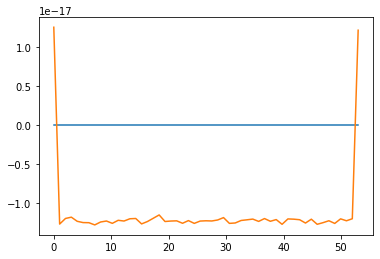

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [17]:
x = np.linspace(0, len(system.F_matrix[:,0]), len(system.F_matrix[:,0]))
plt.plot(x, np.imag(system.F_matrix[:,0]))
plt.plot(x, np.real(system.F_matrix[:,0]))